In [1]:
import numpy as np
import spacetrack.operators as op
from datetime import datetime,timedelta
import pandas as pd
from spacetrack import SpaceTrackClient
from io import StringIO  # Import StringIO
import time
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Model training
import numpy as np
from collections import deque
from typing import Optional, Deque, Union
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
# Save model
import joblib
import os
import glob

# Online Simple Moving Average(SMA) Models


In [4]:
!pwd

/home/noppachanin/Satellite_TLE_Project/SatML/Model_training


In [5]:
resample_tle_df = pd.read_csv('../sample_dataset/sample_daily_records_data.csv')
resample_tle_df.set_index('Epoch', inplace=True)
resample_tle_df.head()

,First Derivative Mean Motion,Inclination (degrees),Right Ascension of the Ascending Node (degrees),Argument of Perigee (degrees),Mean Anomaly (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch
Epoch,,,,,,,,
2022-12-31,0.000157,51.644800,77.042350,208.400550,320.463100,0.000525,15.497978,37584.500000
2023-01-01,0.000166,51.644567,74.151133,211.103567,277.293067,0.000519,15.498221,37593.666667
2023-01-02,0.000175,51.644680,69.554840,215.693640,221.644740,0.000511,15.498584,37608.000000
2023-01-03,0.000162,51.644860,64.713420,219.864140,202.583880,0.000499,15.498874,37623.200000
2023-01-04,0.000142,51.644740,59.072260,225.670000,219.529780,0.000497,15.499123,37640.800000


In [6]:
resample_tle_df.columns

Index(['First Derivative Mean Motion', 'Inclination (degrees)',
       'Right Ascension of the Ascending Node (degrees)',
       'Argument of Perigee (degrees)', 'Mean Anomaly (degrees)',
       'Eccentricity', 'Mean Motion (revolutions per day)',
       'Revolution Number at Epoch'],
      dtype='object')

# Data Preparation

In [7]:
# --- 1. Prepare Sample Data ---
data_for_training = resample_tle_df.iloc[1:,:].copy() # drop the first row like we perform first difference

In [8]:
data_for_training.dropna(inplace=True)

# Column selection for model training

In [9]:
gt_features = ['First Derivative Mean Motion', 'Inclination (degrees)',
       'Right Ascension of the Ascending Node (degrees)',
       'Argument of Perigee (degrees)', 'Mean Anomaly (degrees)',
       'Eccentricity', 'Mean Motion (revolutions per day)',
       'Revolution Number at Epoch']

In [10]:
original_features = ['First Derivative Mean Motion', 'Inclination (degrees)','Eccentricity','Mean Motion (revolutions per day)']

diff_features = ['Revolution Number at Epoch_Diff']

cyclical_features = ['Right Ascension of the Ascending Node (degrees)_sin',
        'Right Ascension of the Ascending Node (degrees)_cos',
        'Argument of Perigee (degrees)_sin',
        'Argument of Perigee (degrees)_cos', 
        'Mean Anomaly (degrees)_sin',
        'Mean Anomaly (degrees)_cos']

In [11]:
all_features = original_features+diff_features+cyclical_features

# Generating lag features

In [12]:
data = data_for_training[gt_features].copy() 
data.head()

,First Derivative Mean Motion,Inclination (degrees),Right Ascension of the Ascending Node (degrees),Argument of Perigee (degrees),Mean Anomaly (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch
Epoch,,,,,,,,
2023-01-01,0.000166,51.644567,74.151133,211.103567,277.293067,0.000519,15.498221,37593.666667
2023-01-02,0.000175,51.644680,69.554840,215.693640,221.644740,0.000511,15.498584,37608.000000
2023-01-03,0.000162,51.644860,64.713420,219.864140,202.583880,0.000499,15.498874,37623.200000
2023-01-04,0.000142,51.644740,59.072260,225.670000,219.529780,0.000497,15.499123,37640.800000
2023-01-05,0.000139,51.644820,54.697760,228.970120,250.770840,0.000490,15.499368,37654.600000


In [13]:
data.to_numpy().shape

(730, 8)

In [14]:
# X_scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()

# X_scaler = StandardScaler()
# y_scaler = StandardScaler()

# X_scaled = X_scaler.fit_transform(data.to_numpy())
# y_scaled = y_scaler.fit_transform(y)

X_scaled = data.to_numpy()

# --- 4. Splitting the Data ---
# For time series, we split chronologically. The last 20% of the data
# will be used for testing.
split_index = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]

X_train.shape, X_test.shape

((584, 8), (146, 8))

# Traing classical ML

In [15]:
class OnlineSimpleMovingAverage:
    """
    Online Simple Moving Average for multiple columns.
    Processes each column independently and predicts future values.
    """
    
    def __init__(self, window_size, n_columns):
        """
        Initialize the Online SMA.
        
        Parameters:
        -----------
        window_size : int
            Number of previous values to consider for moving average
        n_columns : int
            Number of columns in the data
        """
        self.window_size = window_size
        self.n_columns = n_columns
        # Store separate deque for each column
        self.windows = [deque(maxlen=window_size) for _ in range(n_columns)]
        self.sums = np.zeros(n_columns)  # Running sum for each column
        
    def update(self, values):
        """
        Update the moving average with new values.
        
        Parameters:
        -----------
        values : array-like of shape (n_columns,)
            New values for each column
            
        Returns:
        --------
        predictions : np.ndarray of shape (n_columns,)
            Current moving average (prediction) for each column
        """
        values = np.array(values)
        predictions = np.zeros(self.n_columns)
        
        for i in range(self.n_columns):
            # If window is full, subtract the oldest value
            if len(self.windows[i]) == self.window_size:
                self.sums[i] -= self.windows[i][0]
            
            # Add new value
            self.windows[i].append(values[i])
            self.sums[i] += values[i]
            
            # Calculate moving average
            predictions[i] = self.sums[i] / len(self.windows[i])
        
        return predictions
    
    def predict(self):
        """
        Get current prediction without updating.
        
        Returns:
        --------
        predictions : np.ndarray of shape (n_columns,)
            Current moving average for each column
        """
        predictions = np.zeros(self.n_columns)
        
        for i in range(self.n_columns):
            if len(self.windows[i]) > 0:
                predictions[i] = self.sums[i] / len(self.windows[i])
            else:
                predictions[i] = 0.0
        
        return predictions
    
    def reset(self):
        """Reset all windows and sums."""
        self.windows = [deque(maxlen=self.window_size) for _ in range(self.n_columns)]
        self.sums = np.zeros(self.n_columns)

In [16]:
window_size = 3 # current + 2 lags
n_columns = X_test.shape[1]
n_samples = X_test.shape[0]-window_size
sma = OnlineSimpleMovingAverage(window_size=window_size, n_columns=n_columns)

# Process data online and collect predictions
predictions = []

for i in range(n_samples):
    # Update with current row and get prediction for next value
    pred = sma.update(X_test[i])
    predictions.append(pred)

# Convert to numpy array
predictions = np.array(predictions)

print(f"Predictions shape: {predictions.shape}")
print(n_samples)

Predictions shape: (143, 8)
143


# Revert cyclical features and a differencing feature

In [17]:
df_pred_data = pd.DataFrame(data=predictions, columns=gt_features)
df_pred_data

,First Derivative Mean Motion,Inclination (degrees),Right Ascension of the Ascending Node (degrees),Argument of Perigee (degrees),Mean Anomaly (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch
0,0.000192,51.639650,56.032317,176.386000,259.052850,0.000585,15.497731,46666.333333
1,0.000199,51.639900,53.493265,178.477900,253.383069,0.000586,15.497956,46674.291667
2,0.000196,51.640276,50.988681,180.586010,246.052351,0.000583,15.498172,46682.099206
3,0.000209,51.640726,45.999842,184.239454,244.833678,0.000577,15.498638,46697.710317
4,0.000262,51.641065,41.002394,187.826193,243.841177,0.000565,15.499195,46713.349206
...,...,...,...,...,...,...,...,...
138,0.000460,51.638362,96.985315,209.649978,146.646165,0.000516,15.501230,48792.016667
139,0.000236,51.637845,92.255857,121.578528,193.696698,0.000534,15.501621,48806.933333
140,0.000272,51.638072,87.272297,4.886008,263.067985,0.000551,15.502129,48822.600000
141,0.000281,51.638098,82.306670,8.269698,312.324582,0.000569,15.502636,48838.266667


In [18]:
df_test_data = data_for_training.iloc[split_index+window_size:][gt_features]
initial_revs = data_for_training.iloc[split_index+window_size-1,7]#['Revolution Number at Epoch']
df_test_data.shape, gt_features, initial_revs

((143, 8),
 ['First Derivative Mean Motion',
  'Inclination (degrees)',
  'Right Ascension of the Ascending Node (degrees)',
  'Argument of Perigee (degrees)',
  'Mean Anomaly (degrees)',
  'Eccentricity',
  'Mean Motion (revolutions per day)',
  'Revolution Number at Epoch'],
 46697.71428571428)

In [19]:
df_test_data.columns

Index(['First Derivative Mean Motion', 'Inclination (degrees)',
       'Right Ascension of the Ascending Node (degrees)',
       'Argument of Perigee (degrees)', 'Mean Anomaly (degrees)',
       'Eccentricity', 'Mean Motion (revolutions per day)',
       'Revolution Number at Epoch'],
      dtype='object')

# Making prediction

In [20]:
y_actual = df_test_data.values
y_pred = df_pred_data.values

if y_actual.shape != y_pred.shape:
    raise ValueError(f"Actual and prediction arrays must have the same shape. Got {y_actual.shape} and {y_pred.shape}")

# Ensure arrays are at least 2D (even for a single feature)
if y_actual.ndim == 1:
    y_actual = y_actual.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

num_features = y_actual.shape[1]

if gt_features is None:
    gt_features = [f'Feature_{i+1}' for i in range(num_features)]
elif len(gt_features) != num_features:
    raise ValueError(f"The number of feature names ({len(gt_features)}) must match the number of columns ({num_features}).")




In [21]:
metrics_data = {}

for i in range(num_features):
    actual_flat = y_actual[:, i].flatten()
    pred_flat = y_pred[:, i].flatten()

    # Calculate Error
    error = pred_flat - actual_flat

    # --- 1. MSE (Mean Squared Error) ---
    mse = np.mean(error ** 2)

    # --- 2. RMSE (Root Mean Squared Error) ---
    rmse = np.sqrt(mse)

    # --- 3. MAE (Mean Absolute Error) ---
    mae = np.mean(np.abs(error))

    # --- 4. MAPE (Mean Absolute Percentage Error) ---

    #     # Use a mask to avoid division by zero (or near-zero) for the denominator
    #     # We only consider actual values that are meaningfully non-zero
    #     valid_mask = np.abs(actual_flat) > epsilon

    #     if np.any(valid_mask):
    #         # Calculate the percentage error only for valid points
    #         percentage_error = np.abs(error[valid_mask] / actual_flat[valid_mask])
    #         mape = np.mean(percentage_error) * 100
    #     else:
    #         # If all actual values are near zero, MAPE is undefined/unreliable
    #         mape = np.nan 

    metrics_data[gt_features[i]] = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
#         'MAPE (%)': mape
    }

# Convert the dictionary of metrics into a DataFrame
results_df = pd.DataFrame.from_dict(metrics_data, orient='index')
results_df.index.name = 'Feature'

In [22]:
results_df

,RMSE,MSE,MAE
Feature,,,
First Derivative Mean Motion,0.001126,1.267441e-06,0.000334
Inclination (degrees),0.001123,1.260850e-06,0.000764
Right Ascension of the Ascending Node (degrees),76.110743,5.792845e+03,36.856070
Argument of Perigee (degrees),75.031926,5.629790e+03,35.875342
Mean Anomaly (degrees),60.011714,3.601406e+03,41.658010
Eccentricity,0.000111,1.233584e-08,0.000058
Mean Motion (revolutions per day),0.003768,1.419605e-05,0.002781
Revolution Number at Epoch,61.901042,3.831739e+03,61.867091


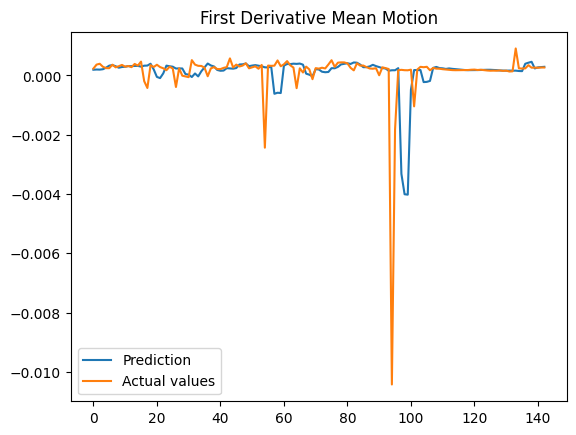

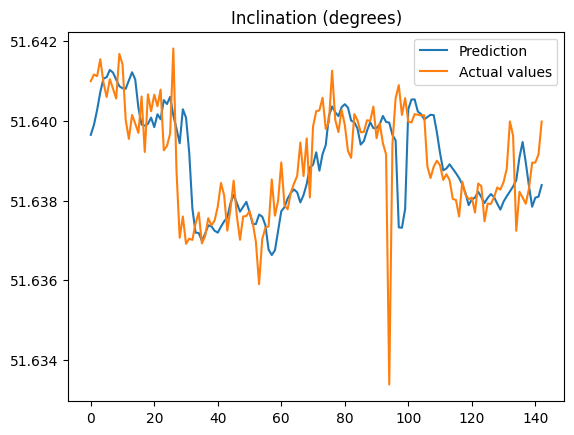

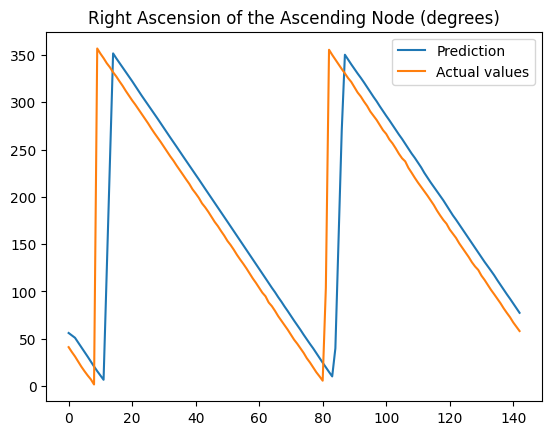

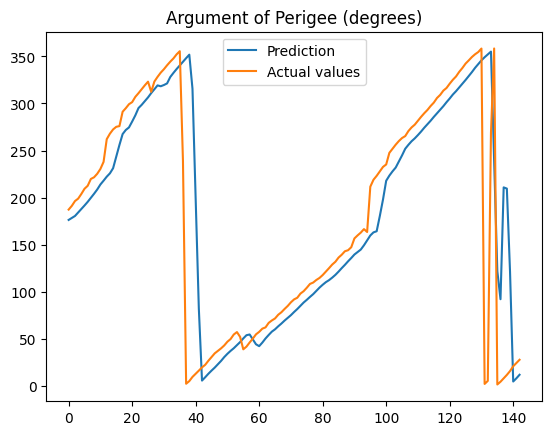

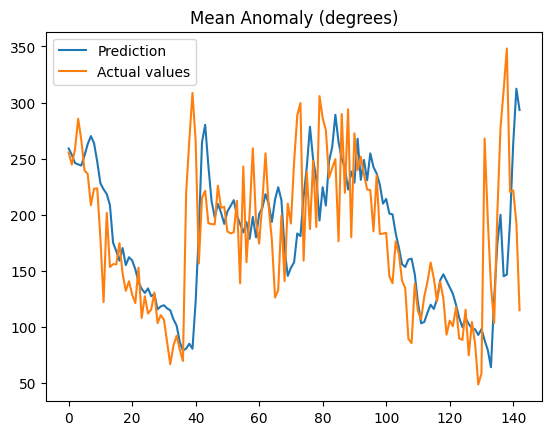

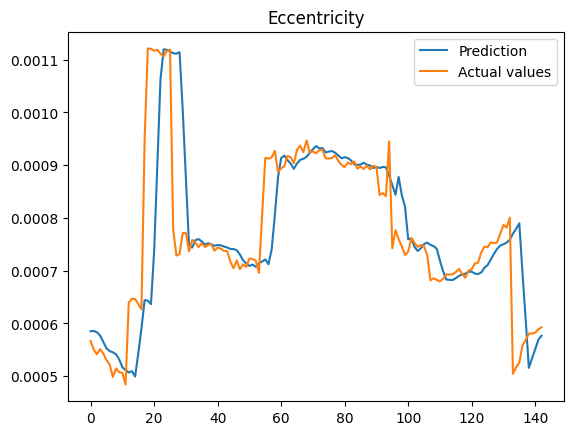

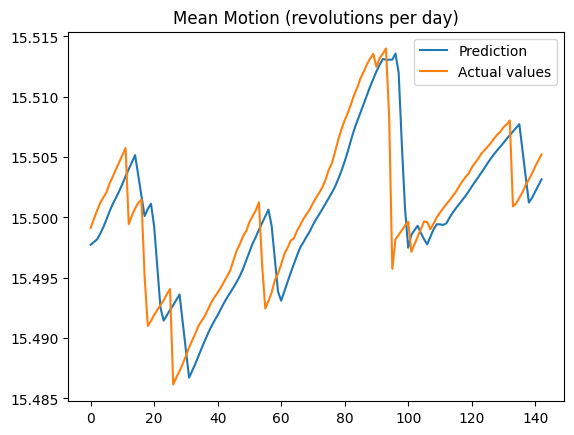

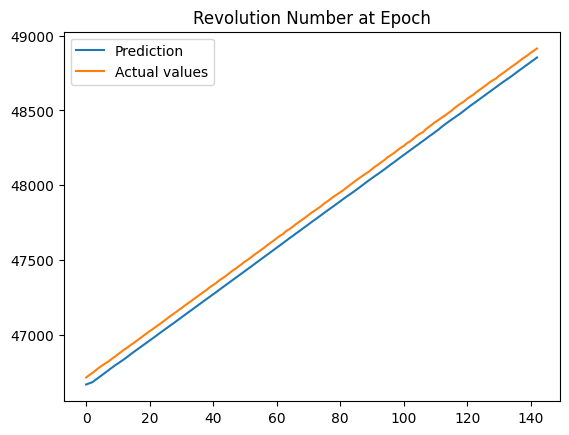

In [23]:
for i in range(num_features):
    actual_flat = y_actual[:, i].flatten()
    pred_flat = y_pred[:, i].flatten()
    
    plt.title(gt_features[i])
    plt.plot(pred_flat, label='Prediction')    
    plt.plot(actual_flat, label='Actual values')
    plt.legend()
    plt.show()